In [1]:
!git clone 'https://github.com/facebookresearch/SlowFast.git'

Cloning into 'SlowFast'...
remote: Enumerating objects: 2058, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 2058 (delta 18), reused 33 (delta 18), pack-reused 2013
Receiving objects: 100% (2058/2058), 31.33 MiB | 27.51 MiB/s, done.
Resolving deltas: 100% (1428/1428), done.


In [2]:
!pip install pyslowfast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.2/105.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 19.6 MB/s eta 0:00:00


In [3]:
!pip install pytorchvideo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=188685 sha256=94ef2bda3f70ded04367fb39a9cc67edce94cefc3f719d0e7eb20d35af8b52db
  Stored in directory: /root/.cache/pip/wheels/ff/4e/81/0f72a543be9ed7eb737c95bfc5da4025e73226b44368074ece
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=593e90ec36313a122880fda626c189e71b6b8178c832991d6cf6c383d910a98c
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=ff5edee98

In [4]:
import torch
import json
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
)
from typing import Dict

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [5]:
device = "cpu"
model_name = "slowfast_r50"
model = torch.hub.load("facebookresearch/pytorchvideo", model=model_name, pretrained=True)
model = model.to(device)
model = model.eval()

Downloading: "https://github.com/facebookresearch/pytorchvideo/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/SLOWFAST_8x8_R50.pyth" to /root/.cache/torch/hub/checkpoints/SLOWFAST_8x8_R50.pyth
100%|██████████| 264M/264M [00:01<00:00, 200MB/s]


In [6]:
!wget https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json

--2023-12-13 08:35:48--  https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.14, 3.163.189.96, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10326 (10K) [text/plain]
Saving to: ‘kinetics_classnames.json’

kinetics_classnames 100%[===================>]  10.08K  --.-KB/s    in 0.001s  

2023-12-13 08:35:48 (17.6 MB/s) - ‘kinetics_classnames.json’ saved [10326/10326]



In [7]:
with open("kinetics_classnames.json", "r") as f:
    kinetics_classnames = json.load(f)

kinetics_id_to_classname = {}
for k, v in kinetics_classnames.items():
    kinetics_id_to_classname[v] = str(k).replace('"', "")

In [8]:
side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 32
sampling_rate = 2
frames_per_second = 30
alpha = 4

class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors.
    """
    def __init__(self):
        super().__init__()

    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list

transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size),
            PackPathway()
        ]
    ),
)

clip_duration = (num_frames * sampling_rate)/frames_per_second

In [9]:
video_path = "/content/TrungvsPhap.mp4"
start_sec = 0
end_sec = start_sec + clip_duration
video = EncodedVideo.from_path(video_path)
video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)

video_data = transform(video_data)
inputs = video_data["video"]
inputs = [i.to(device)[None, ...] for i in inputs]

In [10]:
preds = model(inputs)
post_act = torch.nn.Softmax(dim=1)
preds = post_act(preds)
pred_classes = preds.topk(k=5).indices

# Map the predicted classes to the label names
pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes[0]]
print("Predicted labels: %s" % ", ".join(pred_class_names))

Predicted labels: arm wrestling, rock scissors paper, massaging feet, shaking hands, cutting nails


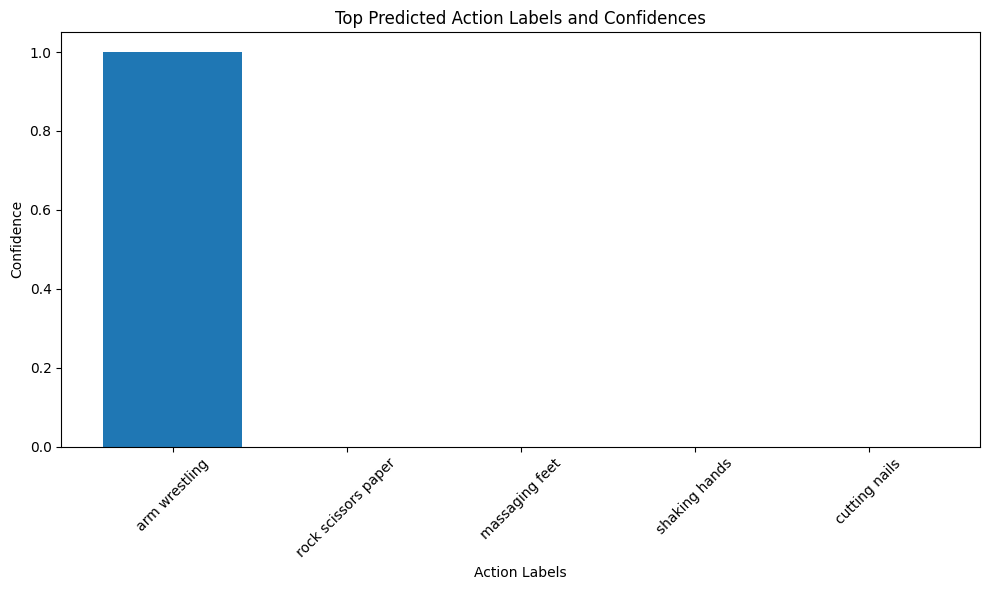

In [32]:
import matplotlib.pyplot as plt
import numpy as np

k = 5
topk_indices = preds.squeeze().topk(k).indices.cpu().numpy()
topk_probabilities = preds.squeeze()[topk_indices].detach().cpu().numpy()

topk_class_names = [kinetics_id_to_classname[int(i)] for i in topk_indices]

plt.figure(figsize=(10, 6))
plt.bar(topk_class_names, topk_probabilities)
plt.xlabel('Action Labels')
plt.ylabel('Confidence')
plt.title('Top Predicted Action Labels and Confidences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

video_capture = cv2.VideoCapture("/content/TrungvsPhap.mp4")

frame_number = 0
while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not ret:
        break

    cv2.putText(frame, f"Frame: {frame_number}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model = model.eval()

    # Get predictions for this frame
    start_sec = frame_number * (clip_duration / num_frames)
    end_sec = start_sec + (clip_duration / num_frames)
    video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)
    video_data = transform(video_data)
    inputs = video_data["video"]
    inputs = [i.to(device)[None, ...] for i in inputs]
    preds = model(inputs)
    post_act = torch.nn.Softmax(dim=1)
    preds = post_act(preds)
    pred_classes = preds.topk(k=5).indices[0]
    pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes]
    label_y = 100
    for label in pred_class_names:
        cv2.putText(frame, label, (50, label_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        label_y += 50

    cv2_imshow(frame)
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

    frame_number += 1

video_capture.release()
cv2.destroyAllWindows()